In [1]:
!python --version

Python 3.11.5


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [3]:
import numpy as np
import pandas as pd

P = 850  
E = 120e9  
nu = 0.25

sigma_max_values = np.linspace(10e6, 70e6, 4) 
delta_u_values = np.linspace(0.2e-3, 0.7e-3, 4)  
alpha_values = np.linspace(2, 7, 3)

def damage_non_linear(delta, delta_c, delta_u, alpha):
    if delta <= delta_c:
        return 0
    else:
        return 1 - (delta_c / delta) * (1 - (1 - np.exp(-alpha * (delta - delta_c) / (delta_u - delta_c))) / (1 - np.exp(-alpha)))

def traction_linear(delta, sigma_max, delta_c, delta_u, D):
    if delta <= delta_c:
        return sigma_max * (delta / delta_c)
    else:
        return sigma_max * (1 - D)

data = []
for sigma_max in sigma_max_values:
    for delta_u in delta_u_values:
        delta_c = 0.01 * delta_u
        for alpha in alpha_values:
            for delta in np.linspace(0, delta_u, 50): 
                D = damage_non_linear(delta, delta_c, delta_u, alpha)
                T = traction_linear(delta, sigma_max, delta_c, delta_u, D)
                data.append([sigma_max, delta_u, delta_c, alpha, delta, D, T])

columns = ['sigma_max', 'delta_u', 'delta_max', 'alpha', 'delta', 'damage', 'traction']
df = pd.DataFrame(data, columns=columns)

df.to_csv('data.csv', index=False)
fracture_energies = []
for sigma_max in sigma_max_values:
    for delta_u in delta_u_values:
        delta_c = 0.01 * delta_u
        for alpha in alpha_values:
            deltas = np.linspace(0, delta_u, 50)
            TSL_curve = []
            for delta in deltas: 
                D = damage_non_linear(delta, delta_c, delta_u, alpha)
                T = traction_linear(delta, sigma_max, delta_c, delta_u, D)
                TSL_curve.append(T)
            
            fracture_energy = np.trapz(TSL_curve, deltas)
            fracture_energies.append(fracture_energy)

min_fracture_energy = np.min(fracture_energies)
max_fracture_energy = np.max(fracture_energies)

print(f"Minimum Fracture Energy: {min_fracture_energy}")
print(f"Maximum Fracture Energy: {max_fracture_energy}")

df

Minimum Fracture Energy: 43.03943503986714
Maximum Fracture Energy: 1485.4769083934352


,sigma_max,delta_u,delta_max,alpha,delta,damage,traction
0,10000000.0,0.0002,0.000002,2.0,0.000000,0.000000,0.000000e+00
1,10000000.0,0.0002,0.000002,2.0,0.000004,0.521791,4.782088e+06
2,10000000.0,0.0002,0.000002,2.0,0.000008,0.772102,2.278981e+06
3,10000000.0,0.0002,0.000002,2.0,0.000012,0.855237,1.447629e+06
4,10000000.0,0.0002,0.000002,2.0,0.000016,0.896588,1.034125e+06
...,...,...,...,...,...,...,...
2395,70000000.0,0.0007,0.000007,7.0,0.000643,0.999992,5.433664e+02
2396,70000000.0,0.0007,0.000007,7.0,0.000657,0.999995,3.686788e+02
2397,70000000.0,0.0007,0.000007,7.0,0.000671,0.999997,2.228449e+02
2398,70000000.0,0.0007,0.000007,7.0,0.000686,0.999999,1.012431e+02


In [4]:
x = df[['sigma_max', 'delta_u', 'delta_max', 'alpha', 'delta']]
y = df['damage']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.to_csv('X_train.csv', index=False)
x_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [5]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (1920, 5)
y_train shape: (1920,)
x_test shape: (480, 5)
y_test shape: (480,)


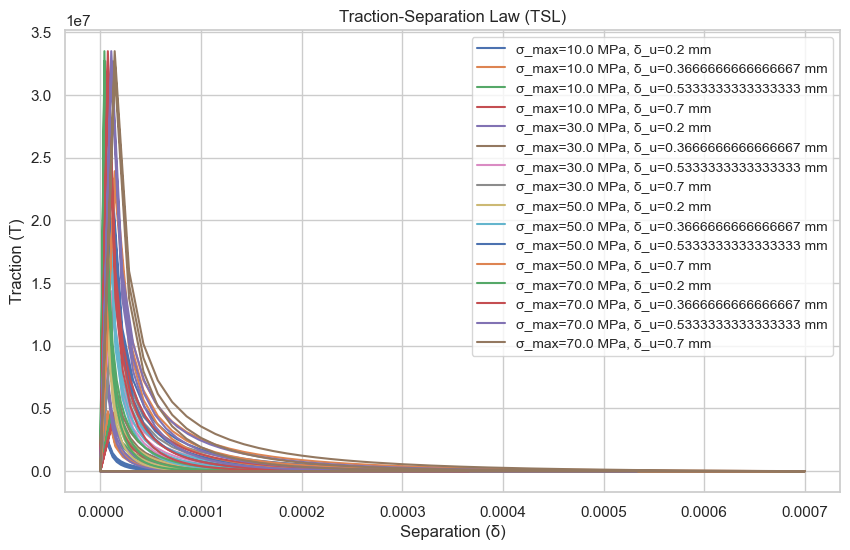

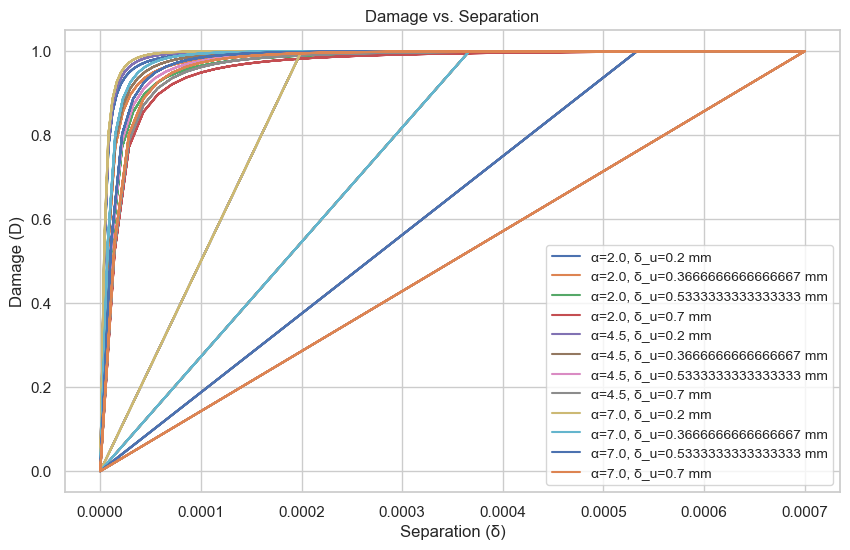

In [6]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
for sigma_max in df['sigma_max'].unique():
    for delta_u in df['delta_u'].unique():
        subset = df[(df['sigma_max'] == sigma_max) & (df['delta_u'] == delta_u)]
        plt.plot(subset['delta'], subset['traction'], label=f'σ_max={sigma_max/1e6} MPa, δ_u={delta_u*1e3} mm')

plt.title('Traction-Separation Law (TSL)')
plt.xlabel('Separation (δ)')
plt.ylabel('Traction (T)')
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for alpha in df['alpha'].unique():
    for delta_u in df['delta_u'].unique():
        subset = df[(df['alpha'] == alpha) & (df['delta_u'] == delta_u)]
        plt.plot(subset['delta'], subset['damage'], label=f'α={alpha}, δ_u={delta_u*1e3} mm')

plt.title('Damage vs. Separation')
plt.xlabel('Separation (δ)')
plt.ylabel('Damage (D)')
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.show()

In [7]:
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
#learning rate kamtar javab behtar mishe
model1 = MLPRegressor(hidden_layer_sizes=(70, 50, 10), activation='relu', solver='adam', learning_rate_init=0.001, max_iter=100)
model1.fit(x_train, y_train)

train_loss1 = model1.loss_
y_pred1 = model1.predict(x_test)
test_loss1 = np.mean((y_test - y_pred1) ** 2)
test_mae1 = np.mean(np.abs(y_test - y_pred1))

print(f'ANN1 - Train Loss: {train_loss1}')
print(f'ANN1 - Test Loss: {test_loss1}')
print(f'ANN1 - Test MAE: {test_mae1}')


ANN1 - Train Loss: 0.5323323650034781
ANN1 - Test Loss: 0.9762138405681694
ANN1 - Test MAE: 0.8666933917245604


Epoch 1/100
60/60 [==============================] - 1s 2ms/step - loss: 35799187456.0000 - mae: 34288.2617 - val_loss: 0.9172 - val_mae: 0.9427
Epoch 2/100
60/60 [==============================] - 0s 942us/step - loss: 0.9183 - mae: 0.9468 - val_loss: 0.9172 - val_mae: 0.9426
Epoch 3/100
60/60 [==============================] - 0s 896us/step - loss: 0.9183 - mae: 0.9468 - val_loss: 0.9172 - val_mae: 0.9426
Epoch 4/100
60/60 [==============================] - 0s 855us/step - loss: 0.9183 - mae: 0.9468 - val_loss: 0.9172 - val_mae: 0.9426
Epoch 5/100
60/60 [==============================] - 0s 883us/step - loss: 0.9183 - mae: 0.9468 - val_loss: 0.9172 - val_mae: 0.9426
Epoch 6/100
60/60 [==============================] - 0s 873us/step - loss: 0.9183 - mae: 0.9468 - val_loss: 0.9172 - val_mae: 0.9426
Epoch 7/100
60/60 [==============================] - 0s 835us/step - loss: 0.9183 - mae: 0.9467 - val_loss: 0.9172 - val_mae: 0.9426
Epoch 8/100
60/60 [==============================] - 0s 8

60/60 [==============================] - 0s 891us/step - loss: 0.9178 - mae: 0.9465 - val_loss: 0.9168 - val_mae: 0.9424
Epoch 63/100
60/60 [==============================] - 0s 1ms/step - loss: 0.9178 - mae: 0.9465 - val_loss: 0.9167 - val_mae: 0.9424
Epoch 64/100
60/60 [==============================] - 0s 979us/step - loss: 0.9178 - mae: 0.9465 - val_loss: 0.9167 - val_mae: 0.9424
Epoch 65/100
60/60 [==============================] - 0s 923us/step - loss: 0.9178 - mae: 0.9465 - val_loss: 0.9167 - val_mae: 0.9424
Epoch 66/100
60/60 [==============================] - 0s 950us/step - loss: 0.9178 - mae: 0.9465 - val_loss: 0.9167 - val_mae: 0.9424
Epoch 67/100
60/60 [==============================] - 0s 919us/step - loss: 0.9178 - mae: 0.9465 - val_loss: 0.9167 - val_mae: 0.9424
Epoch 68/100
60/60 [==============================] - 0s 887us/step - loss: 0.9177 - mae: 0.9465 - val_loss: 0.9166 - val_mae: 0.9424
Epoch 69/100
60/60 [==============================] - 0s 873us/step - loss: 0

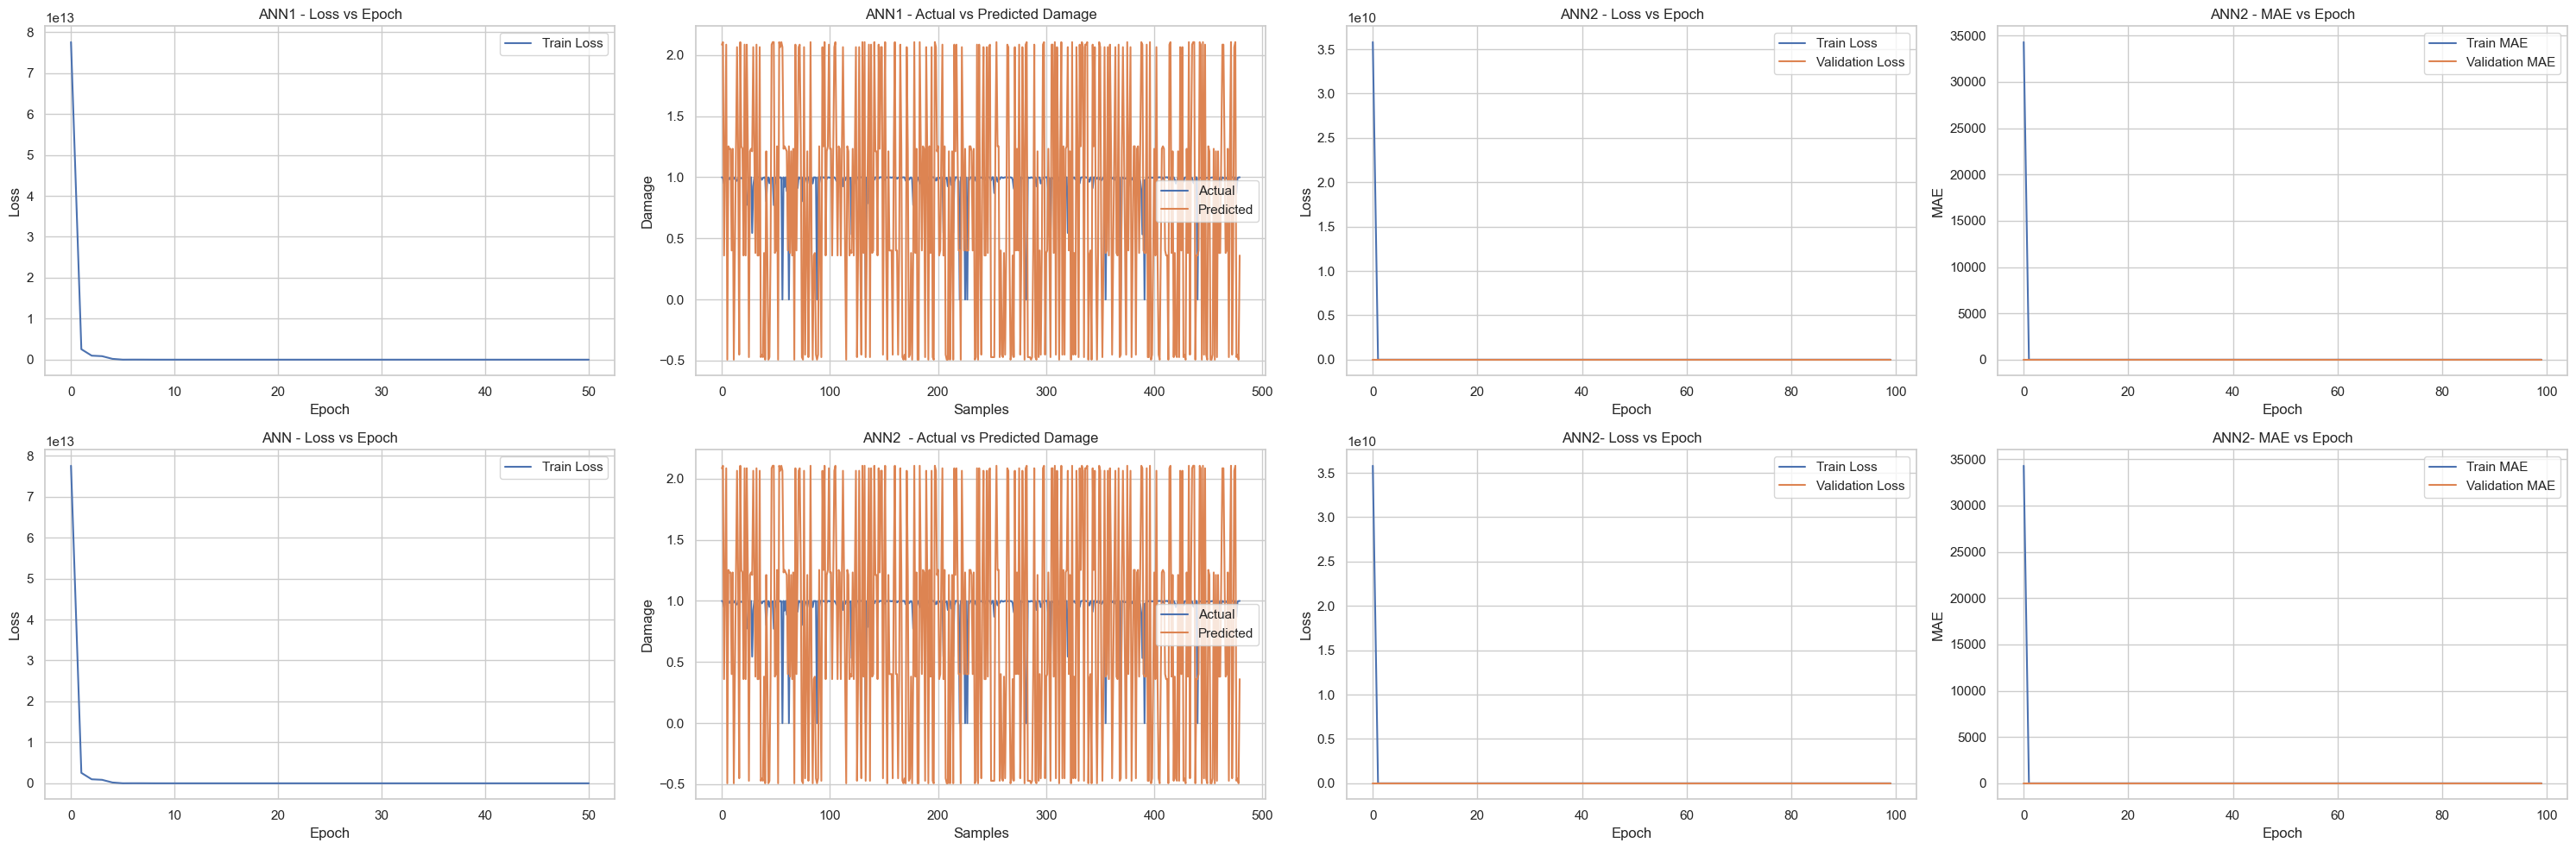

In [8]:
model2 = Sequential()
model2.add(Dense(70, input_dim=x_train.shape[1], activation='relu'))   
model2.add(Dense(50, activation='relu'))  
model2.add(Dense(10, activation='relu'))  
model2.add(Dense(1, activation='linear'))  

model2.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

history = model2.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))

loss2, mae2 = model2.evaluate(x_test, y_test)
print(f'ANN2 - Test Loss: {loss2}')
print(f'ANN2 - Test MAE: {mae2}')

plt.figure(figsize=(30, 10))

plt.subplot(2, 4, 1)
plt.plot(model1.loss_curve_, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('ANN1 - Loss vs Epoch')

plt.subplot(2, 4, 2)
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred1, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Damage')
plt.legend()
plt.title('ANN1 - Actual vs Predicted Damage')

plt.subplot(2, 4, 3)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('ANN2 - Loss vs Epoch')

plt.subplot(2, 4, 4)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('ANN2 - MAE vs Epoch')



plt.subplot(2, 4, 5)
plt.plot(model1.loss_curve_, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f'ANN - Loss vs Epoch')

plt.subplot(2, 4, 6)
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred1, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Damage')
plt.legend()
plt.title(f'ANN2  - Actual vs Predicted Damage')

plt.subplot(2, 4, 7)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f'ANN2- Loss vs Epoch')

plt.subplot(2, 4, 8)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title(f'ANN2- MAE vs Epoch')



plt.tight_layout()
plt.show()

ANN1 - Test Loss: 0.04495841019297943
ANN1 - Test MAE: 0.1797589902012606


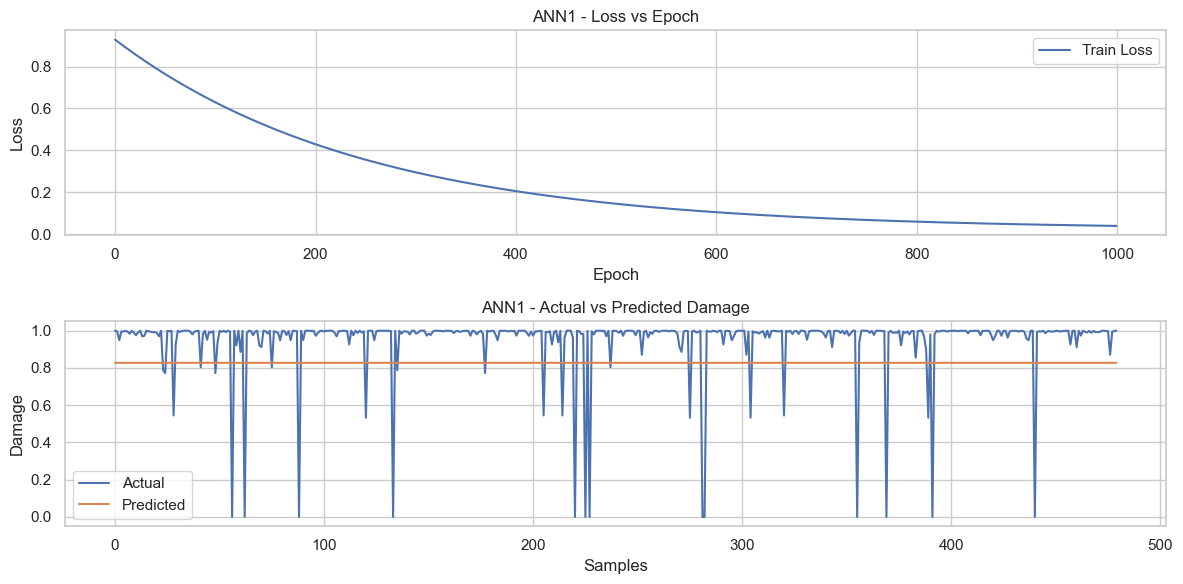

In [9]:

from sklearn.preprocessing import StandardScaler


X = df[['sigma_max', 'delta_u', 'delta_max', 'alpha', 'delta']].values
y = df['damage'].values.reshape(-1, 1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mean_squared_error_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size

input_size = X_train.shape[1]
hidden_layer1_size = 70
hidden_layer2_size = 50
hidden_layer3_size = 10
output_size = 1
learning_rate = 0.001 
epochs = 1000

np.random.seed(42)
W1 = np.random.randn(input_size, hidden_layer1_size) * 0.01
b1 = np.random.randn(hidden_layer1_size) * 0.01
W2 = np.random.randn(hidden_layer1_size, hidden_layer2_size) * 0.01
b2 = np.random.randn(hidden_layer2_size) * 0.01
W3 = np.random.randn(hidden_layer2_size, hidden_layer3_size) * 0.01
b3 = np.random.randn(hidden_layer3_size) * 0.01
W4 = np.random.randn(hidden_layer3_size, output_size) * 0.01
b4 = np.random.randn(output_size) * 0.01

losses = []
for epoch in range(epochs):
    z1 = np.dot(X_train, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = relu(z3)
    z4 = np.dot(a3, W4) + b4
    y_pred = z4
    
    loss = mean_squared_error(y_train, y_pred)
    losses.append(loss)
    
    dL_dy_pred = mean_squared_error_derivative(y_train, y_pred)
    dL_dW4 = np.dot(a3.T, dL_dy_pred)
    dL_db4 = np.sum(dL_dy_pred, axis=0)
    dL_da3 = np.dot(dL_dy_pred, W4.T)
    dL_dz3 = dL_da3 * relu_derivative(z3)
    dL_dW3 = np.dot(a2.T, dL_dz3)
    dL_db3 = np.sum(dL_dz3, axis=0)
    dL_da2 = np.dot(dL_dz3, W3.T)
    dL_dz2 = dL_da2 * relu_derivative(z2)
    dL_dW2 = np.dot(a1.T, dL_dz2)
    dL_db2 = np.sum(dL_dz2, axis=0)
    dL_da1 = np.dot(dL_dz2, W2.T)
    dL_dz1 = dL_da1 * relu_derivative(z1)
    dL_dW1 = np.dot(X_train.T, dL_dz1)
    dL_db1 = np.sum(dL_dz1, axis=0)
    
    W1 -= learning_rate * dL_dW1
    b1 -= learning_rate * dL_db1
    W2 -= learning_rate * dL_dW2
    b2 -= learning_rate * dL_db2
    W3 -= learning_rate * dL_dW3
    b3 -= learning_rate * dL_db3
    W4 -= learning_rate * dL_dW4
    b4 -= learning_rate * dL_db4

z1 = np.dot(X_test, W1) + b1
a1 = relu(z1)
z2 = np.dot(a1, W2) + b2
a2 = relu(z2)
z3 = np.dot(a2, W3) + b3
a3 = relu(z3)
z4 = np.dot(a3, W4) + b4
y_pred_test = z4

test_loss = mean_squared_error(y_test, y_pred_test)
test_mae = np.mean(np.abs(y_test - y_pred_test))

print(f'ANN1 - Test Loss: {test_loss}')
print(f'ANN1 - Test MAE: {test_mae}')

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('ANN1 - Loss vs Epoch')

plt.subplot(2, 1, 2)
plt.plot(y_test, label='Actual')
plt.plot(y_pred_test, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Damage')
plt.legend()
plt.title('ANN1 - Actual vs Predicted Damage')

plt.tight_layout()
plt.show()

ANN1 - Train Loss: 0.0017279299962401338
ANN1 - Test Loss: 0.05379569552353278
ANN1 - Test MAE: 0.09145256227199566


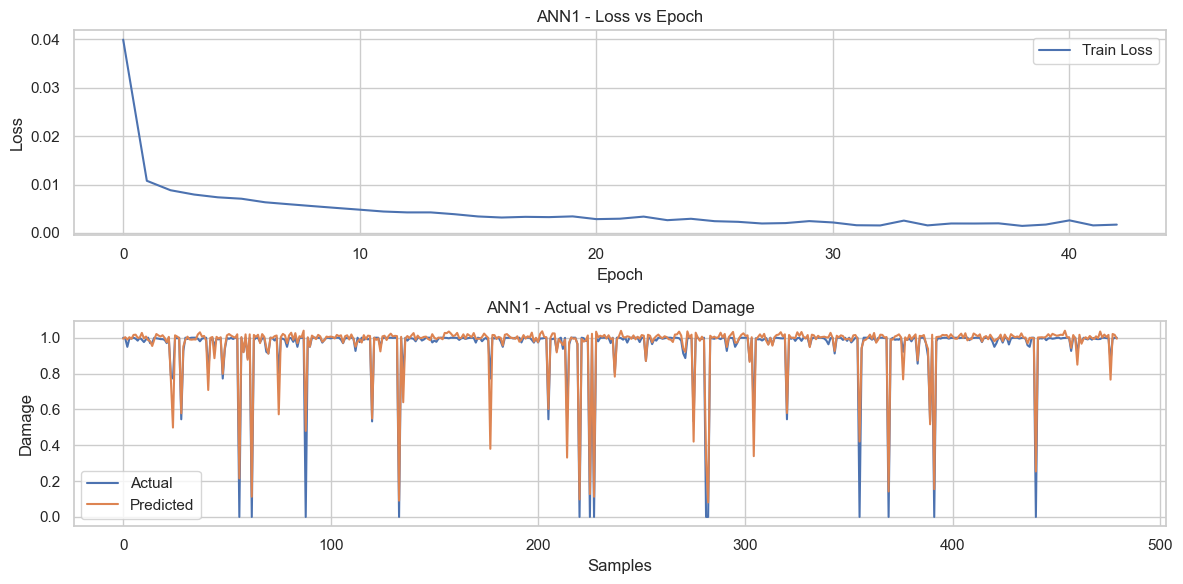

In [10]:



X = df[['sigma_max', 'delta_u', 'delta_max', 'alpha', 'delta']].values
y = df['damage'].values.reshape(-1, 1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model1 = MLPRegressor(hidden_layer_sizes=(100, 50, 25), activation='relu', solver='adam', learning_rate_init=0.001, max_iter=100, batch_size=32, random_state=42)

model1.fit(X_train, y_train.ravel())

train_loss1 = model1.loss_
y_pred1 = model1.predict(X_test)
test_loss1 = np.mean((y_test - y_pred1) ** 2)
test_mae1 = np.mean(np.abs(y_test - y_pred1))

print(f'ANN1 - Train Loss: {train_loss1}')
print(f'ANN1 - Test Loss: {test_loss1}')
print(f'ANN1 - Test MAE: {test_mae1}')

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(model1.loss_curve_, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('ANN1 - Loss vs Epoch')

plt.subplot(2, 1, 2)
plt.plot(y_test, label='Actual')
plt.plot(y_pred1, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Damage')
plt.legend()
plt.title('ANN1 - Actual vs Predicted Damage')

plt.tight_layout()
plt.show()

In [11]:
delta_c = 0.01
delta = 0.005
new_input_sets = np.array([
    [55, 0.55, delta_c, 4.5, delta],  
    [65, 0.65, delta_c, 6.0, delta],  
    [45, 0.35, delta_c, 5.5, delta]  
])

predictions_ann1 = model1.predict(new_input_sets)
predictions_ann2 = model2.predict(new_input_sets)

print("Predictions from ANN1:", predictions_ann1)
print("Predictions from ANN2:", predictions_ann2)

1/1 [==============================] - 0s 94ms/step
Predictions from ANN1: [3.47001706 3.59929962 3.12036058]
Predictions from ANN2: [[-0.02809108]
 [-0.0673283 ]
 [-0.11223228]]


In [12]:

sigma_max_values_mpa = np.array([55, 65, 75])  
delta_max_values_mm = np.array([4.5, 5.5, 6.5])  

sigma_max_values_pa = sigma_max_values_mpa * 1e6 
delta_max_values_m = delta_max_values_mm * 1e-3  
delta_c = 0.001
delta = 0.005   
new_input_sets = np.column_stack((sigma_max_values_pa, delta_max_values_m, [delta_c] * len(sigma_max_values_pa), delta_max_values_m, [delta] * len(sigma_max_values_pa)))

print(new_input_sets)

predictions_ann1 = model1.predict(new_input_sets)
predictions_ann2 = model2.predict(new_input_sets)

print("Predictions from ANN1:", predictions_ann1)
print("Predictions from ANN2:", predictions_ann2)

[[5.5e+07 4.5e-03 1.0e-03 4.5e-03 5.0e-03]
 [6.5e+07 5.5e-03 1.0e-03 5.5e-03 5.0e-03]
 [7.5e+07 6.5e-03 1.0e-03 6.5e-03 5.0e-03]]
1/1 [==============================] - 0s 12ms/step
Predictions from ANN1: [1081689.10796368 1278359.39306822 1475029.67817275]
Predictions from ANN2: [[0.01015588]
 [0.01015588]
 [0.01015588]]


In [13]:
def calculate_fracture_energy(damage_predictions, delta_max, sigma_max):
    fracture_energy = 0.5 * sigma_max * delta_max * (1 - damage_predictions)
    return fracture_energy

for i, (damage_ann1, damage_ann2) in enumerate(zip(predictions_ann1, predictions_ann2)):
    delta_max = new_input_sets[i][3]
    sigma_max = new_input_sets[i][0]

    energy_ann1 = calculate_fracture_energy(damage_ann1, delta_max, sigma_max)
    energy_ann2 = calculate_fracture_energy(damage_ann2, delta_max, sigma_max)

    print(f"Set {i+1} - ANN1 Fracture Energy: {energy_ann1}")
    print(f"Set {i+1} - ANN2 Fracture Energy: {energy_ann2}")

Set 1 - ANN1 Fracture Energy: -133858903360.50496
Set 1 - ANN2 Fracture Energy: [122493.21]
Set 2 - ANN1 Fracture Energy: -228506562760.94345
Set 2 - ANN2 Fracture Energy: [176934.64]
Set 3 - ANN1 Fracture Energy: -359538240304.609
Set 3 - ANN2 Fracture Energy: [241274.52]


In [14]:
min_energy, max_energy = 0.1, 1.0  

for i, (energy_ann1, energy_ann2) in enumerate(zip(predictions_ann1, predictions_ann2)):
    energy_ann1_in_range = (min_energy <= energy_ann1 <= max_energy)
    energy_ann2_in_range = (min_energy <= energy_ann2 <= max_energy)
    
    print(f"Set {i+1}: ANN1 Energy within range? {energy_ann1_in_range}")
    print(f"Set {i+1}: ANN2 Energy within range? {energy_ann2_in_range}")



Set 1: ANN1 Energy within range? False
Set 1: ANN2 Energy within range? [True]
Set 2: ANN1 Energy within range? False
Set 2: ANN2 Energy within range? [True]
Set 3: ANN1 Energy within range? False
Set 3: ANN2 Energy within range? [True]
